# Spatial Data Assimilation in Geologic CO2 Sequestration
## Misael M. Morales - Summer 2023 - LANL

In [1]:
# Load packages, class, and functions
from utils import *
sda = spatialDA()
sda.check_torch_gpu()
#octave = sda.mrst_startup()

argument of type 'NoneType' is not iterable
-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520



True Perm: (2601,) | True Saturation: (3, 2601)
Perm Ensemble: (100, 2601) | Saturation Ensemble: (100, 3, 2601)
Perm All shape: (101, 2601)


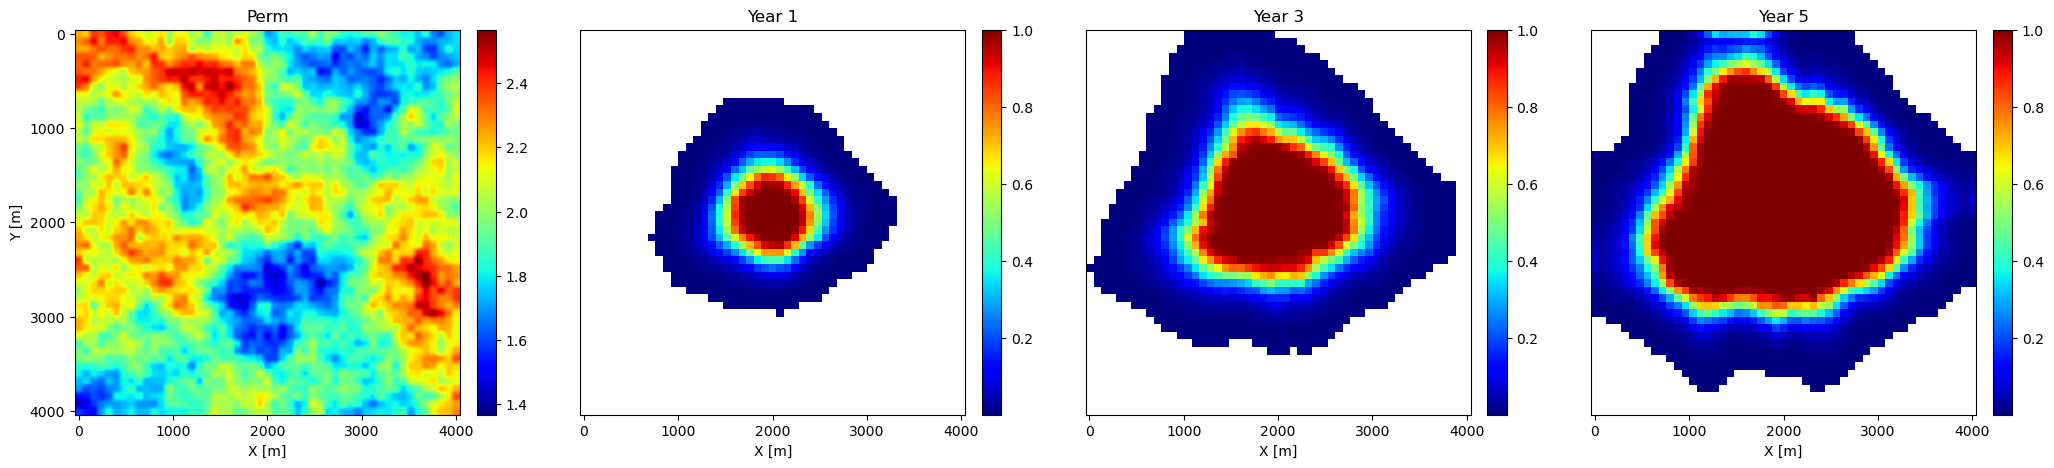

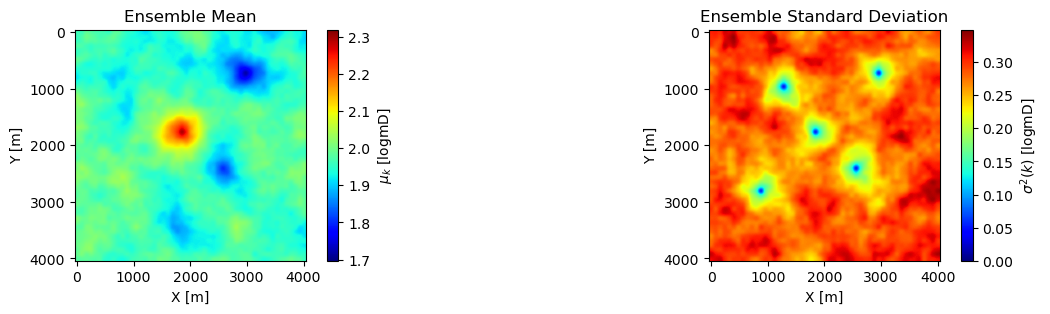

In [2]:
# Load permeability (true, ensemble) and saturation (true)
perm_true, sat_true = sda.load_perm_sat_true()
perm_ens,  sat_ens  = sda.load_perm_sat_ens()
perm_all            = sda.load_perm_all()
sat_true_bc         = np.load('true_sat_bc.npy')

sda.plot_perm_sat(perm_true, sat_true_bc)
sda.plot_ens_mean_std()

***
### Proxy

In [325]:
import torch
import torch.nn as nn
from torch.nn import Conv2d, ConvTranspose2d, BatchNorm2d, MaxPool2d, LSTM, ReLU, InstanceNorm2d
from torch.nn import Sequential

(300, 2, 51, 51)
(300, 1, 51, 51)


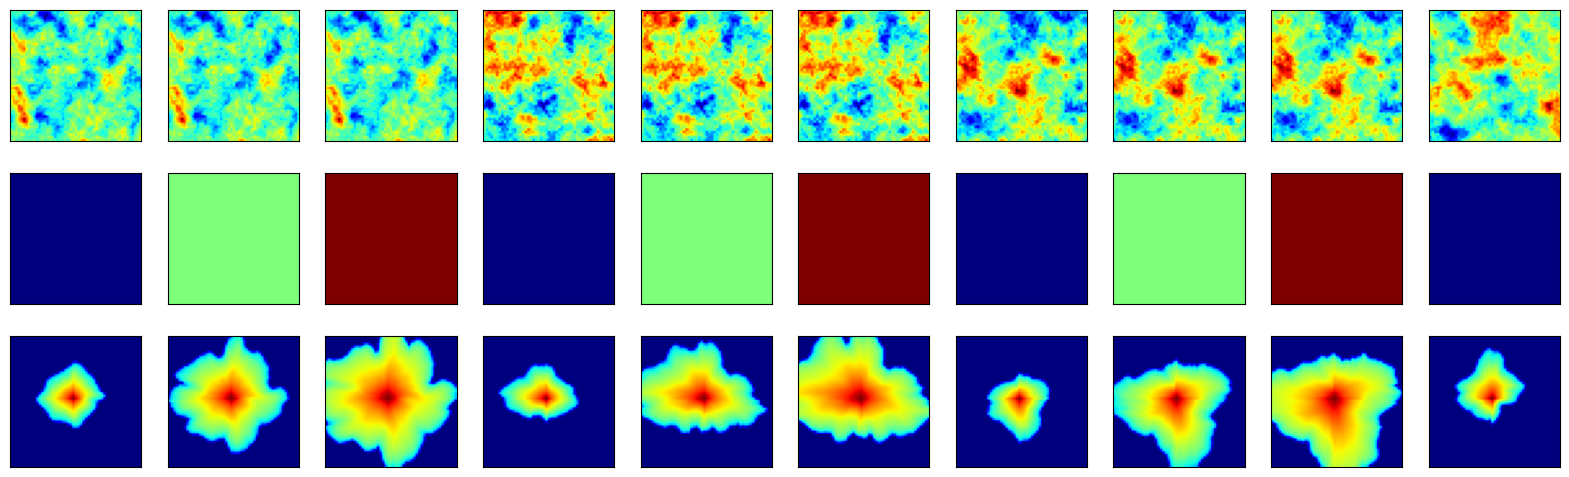

In [431]:
t_steps = [1, 3, 5]
perm_train = repmat(perm_ens, 1, 3).reshape(100,3,1,51,51)
times = np.moveaxis((np.ones((100,1,51,51,3))*t_steps), -1,1).reshape(100,3,1,51,51)

X_train = np.concatenate([perm_train, times], 2).reshape(300,2,51,51)
print(X_train.shape)

y_train = sat_ens.reshape(300,1,51,51)
print(y_train.shape)

fig, axs = plt.subplots(3, 10, figsize=(20,6))
for j in range(10):
    axs[0,j].imshow(X_train[j,0], 'jet')
    axs[1,j].imshow(X_train[j,1], 'jet', vmin=1, vmax=5)
    axs[2,j].imshow(y_train[j,0], 'jet')
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])
plt.show()

In [441]:
class proxy(nn.Module):
    def __init__(self):
        super(proxy, self).__init__()

        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        
        def conv_block(inp, out):
            x = Sequential(
                Conv2d(inp, out, kernel_size=3, padding=1),
                InstanceNorm2d(out),
                ReLU())
            return x
        
        def convT_block(inp, out):
            x = Sequential(
                ConvTranspose2d(inp, out, kernel_size=4, stride=2, padding=1),
                Conv2d(out, out, kernel_size=3, padding=1),
                InstanceNorm2d(out),
                ReLU())
            return x
        
        self.layer1 = conv_block(2, 64)
        self.layer2 = conv_block(64, 128)
        self.layer3 = conv_block(128, 256)
        self.layer4 = conv_block(256, 512)
        
        self.layer4T = convT_block(512, 256)
        self.layer3T = convT_block(256, 128)
        self.layer2T = convT_block(128, 64)
        self.layer1T = convT_block(64, 8)
        
        self.out  = Conv2d(8, 1, kernel_size=4, padding=3)
        
    def forward(self, x):
        _ = self.maxpool(self.layer1(x))
        _ = self.maxpool(self.layer2(_))
        _ = self.maxpool(self.layer3(_))
        _ = self.maxpool(self.layer4(_))
        _ = self.layer4T(_)
        _ = self.layer3T(_)
        _ = self.layer2T(_)
        _ = self.layer1T(_)
        out = self.out(_)
        return out

In [442]:
device = 'cuda'
model = proxy().to(device)

x = torch.tensor(X_train).float()
y = torch.tensor(y_train).float()

epochs = 100
batch_size = 20
loss, val_loss = [], []
metrics = {'loss':[], 'val_loss':[]}
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for i in range(0, len(x), batch_size):
        inp  = x[i:i+batch_size].to(device)
        true = y[i:i+batch_size].to(device)
        optimizer.zero_grad()
        pred = model(inp)
        loss = loss_fn(pred, true)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*inp.size(0)
    metrics['loss'].append(epoch_loss/len(x))

y_pred: (300, 1, 51, 51)
SSIM = 94.80%


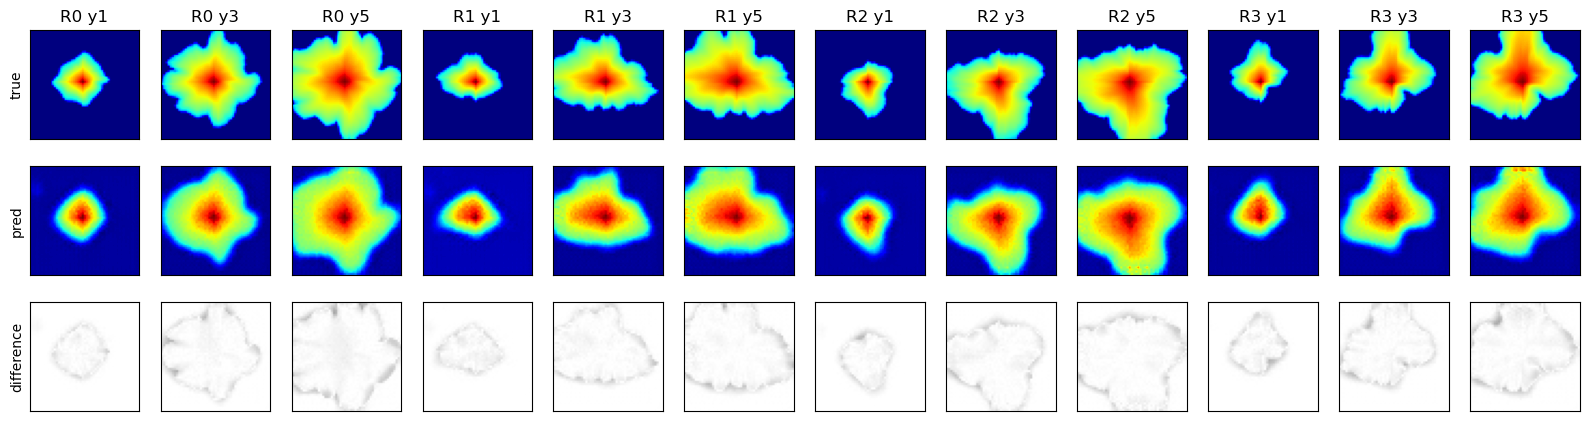

In [464]:
y_pred = model(x.to(device)).detach().cpu().numpy().astype('float64')
print('y_pred:', y_pred.shape)

print('SSIM = {:.2f}%'.format(100*ssim(y_train, y_pred, channel_axis=1)))

labs = ['true', 'pred', 'difference']
fig, axs = plt.subplots(3, 12, figsize=(20,5))
t = 0
for j in range(12):
    nreal = j//3
    true = y_train[j,0]
    pred = y_pred[j,0]
    axs[0,j].imshow(true, 'jet')
    axs[1,j].imshow(pred, 'jet')
    er = axs[2,j].imshow(np.abs(true-pred), 'binary', vmin=0, vmax=1)
    axs[0,j].set(title='R{} y{}'.format(nreal, t_steps[t]))
    t += 1
    if t==3:
        t = 0
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])
        axs[i,0].set(ylabel=labs[i])
plt.show()

***
### ESMDA-GEO

In [188]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

true: (100, 2601) | predicted: (100, 2601)


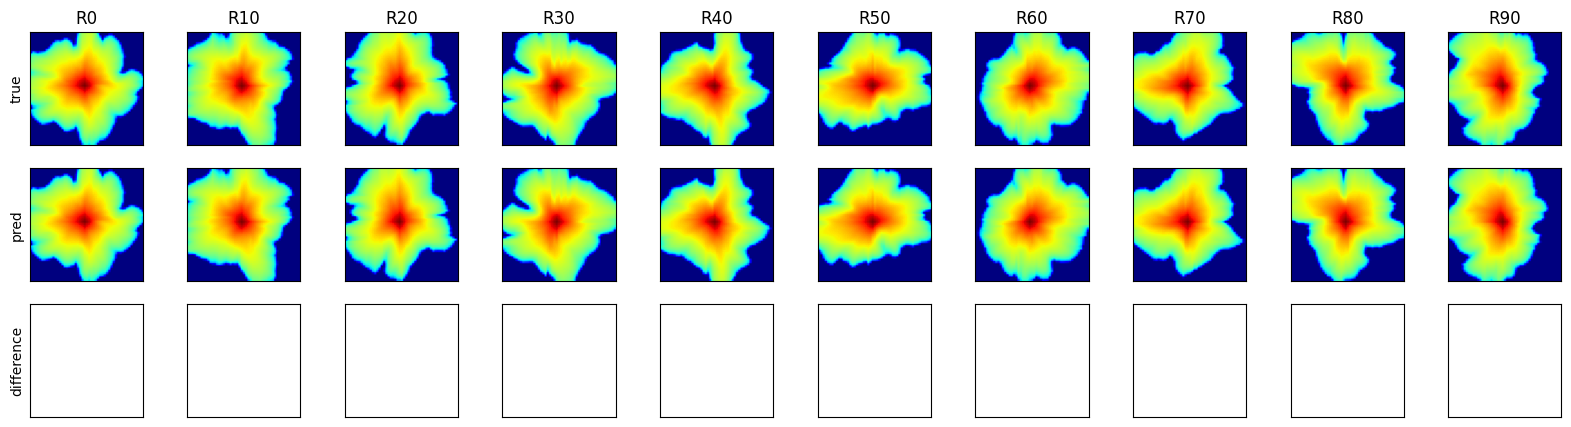

In [210]:
layer = 1
y_true = sat_ens[:,layer]

reg = DecisionTreeRegressor()
reg.fit(perm_ens, y_true)
y_pred = reg.predict(perm_ens)
print('true: {} | predicted: {}'.format(y_true.shape, y_pred.shape))

fig, axs = plt.subplots(3, 10, figsize=(20,5))
for i in range(10):
    k = i*10
    true, pred = y_true[k].reshape(51,51), y_pred[k].reshape(51,51)
    axs[0,i].imshow(true, 'jet'); axs[0,0].set(ylabel='true')
    axs[1,i].imshow(pred, 'jet'); axs[1,0].set(ylabel='pred')
    axs[2,i].imshow(np.abs(true-pred), cmap='binary'); axs[2,0].set(ylabel='difference')
    axs[0,i].set(title='R{}'.format(k))
    for j in range(3):
        axs[j,i].set(xticks=[], yticks=[])

In [229]:
# Ensemble
m_ensemble = perm_ens
print('m_ensemble: {}'.format(m_ensemble.shape))

# Observations
obs     = sat_true[layer]
cov_obs = approximate_cov_mm(m_ensemble)
print('obs: {} | cov_obs: {}'.format(obs.shape, cov_obs.shape))

n_assimilations = 4

# ESMDA
def forward_model(ens):
    return reg.predict(ens)

solver = ESMDA(obs=obs, m_init=m_ensemble, cov_obs=cov_obs, 
               forward_model             = forward_model,
               n_assimilations           = n_assimilations,
               save_ensembles_history    = True)
solver.solve()

m_ensemble: (100, 2601)
obs: (2601,) | cov_obs: (2601, 2601)
Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4


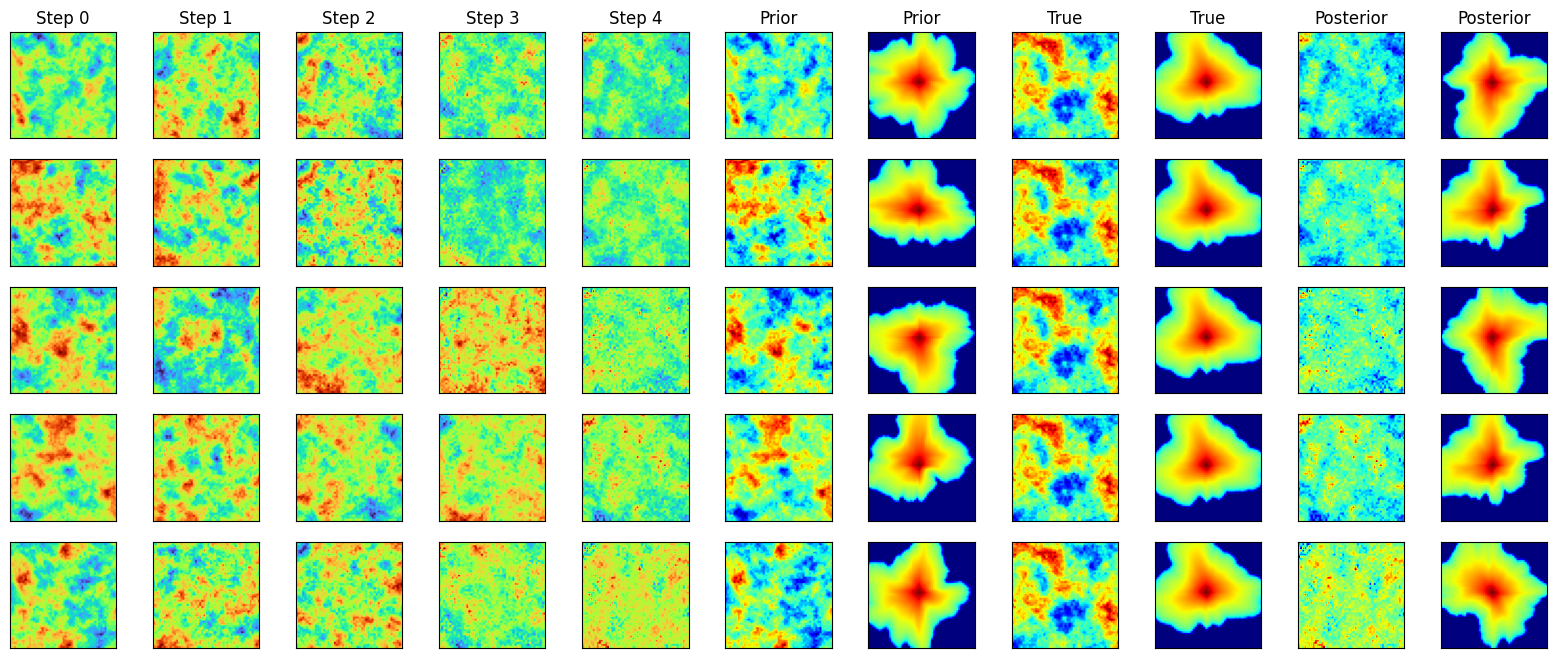

In [230]:
temp = np.array(solver.m_history)
n_steps = temp.shape[0]

fig, axs = plt.subplots(5, n_steps+6, figsize=(20,8))
for i in range(5):
    for j in range(n_steps):
        axs[i,j].imshow(temp[j,i].reshape(51,51), cmap='turbo'); axs[0,j].set(title='Step {}'.format(j))
    for j in range(n_steps+6):
        axs[i,j].set(xticks=[], yticks=[])

    axs[i,n_steps].imshow(perm_ens[i].reshape(51,51), 'jet'); axs[0,n_steps].set(title='Prior')
    axs[i,n_steps+1].imshow(sat_ens[i,layer].reshape(51,51), 'jet'); axs[0,n_steps+1].set(title='Prior')

    axs[i,n_steps+2].imshow(perm_true.reshape(51,51), 'jet'); axs[0,n_steps+2].set(title='True')
    axs[i,n_steps+3].imshow(sat_true[layer].reshape(51,51), 'jet'); axs[0,n_steps+3].set(title='True')

    axs[i,n_steps+4].imshow(solver.m_prior[i].reshape(51,51), 'jet'); axs[0,n_steps+4].set(title='Posterior')
    axs[i,n_steps+5].imshow(solver.d_pred[i].reshape(51,51), 'jet'); axs[0,n_steps+5].set(title='Posterior')

***
# END